# RNN Sentiment Analysis

Import Dependencies

In [1]:
%store -r initial_processing_df
%store -r rnn_df

from tqdm.notebook import tqdm

from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, SimpleRNN, Embedding, LSTM
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import ModelCheckpoint


import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import keras
import random
import nltk
import re

np.random.seed(124)
tf.random.set_seed(124)

nltk.download('stopwords')
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nawid\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = rnn_df
df.head()

,Review Text,Review Rating,Positive,Character_Count,Word_count
0,Siamo stati a Londra per un week end ed abbiam...,5,1,1063,171
1,I had a pleasure of staying in this hotel for ...,5,1,1425,265
2,A very lovely first visit to this iconic hotel...,5,1,324,54
3,3 of us stayed at the Rhodes Hotel for 4 night...,4,1,425,75
4,Form the moment we arrived until we left we ex...,5,1,363,62


## NLTK

In [3]:
def preprocess_text(sen):
    '''Cleans up text data, leaving 2 or more char long non-stopwords containing A-Z & a-z only in lowercase'''
    
    sentence = sen.lower()
    
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    
    # Remove single character
    sentence = re.sub(r"\s+[^a-zA-Z]\s+", ' ', sentence)
    
    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    
    # Remove stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)
    
    return sentence

In [4]:
x = []

sentences = list(df['Review Text'])
for sen in sentences:
    x.append(preprocess_text(sen))

## Splitting Data to Train Test

In [5]:
#x = df['Review Text']
x = np.array(x)
y = df['Positive']

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

print("shape of x_train:", x_train.shape)
print("shape of x_test:", x_test.shape)

print("shape of y_train:", y_train.shape)
print("shape of y_test:", y_test.shape)


shape of x_train: (21864,)
shape of x_test: (5466,)
shape of y_train: (21864,)
shape of y_test: (5466,)


# More Preprocessing

It's apparent that the reviews vary in lengths, which is problematic. Neural networks cannot accept data of different lengths. Therefore, it is imperative that we standardize the length of each review. To accomplish this, we need to:

* Determine a fxied number of word.
* Tokenize the words.
* Pad the text.

## Determine Number of Words

In [7]:
# Checking mean and std
df["Word_count"].describe()

count    27330.000000
mean       128.819539
std        128.600239
min          1.000000
25%         55.000000
50%         91.000000
75%        156.000000
max       5781.000000
Name: Word_count, dtype: float64

### Visual Inspection

Upon careful examination of both visuals, it becomes apparent that around 350 words represents the optimal maximum word count.

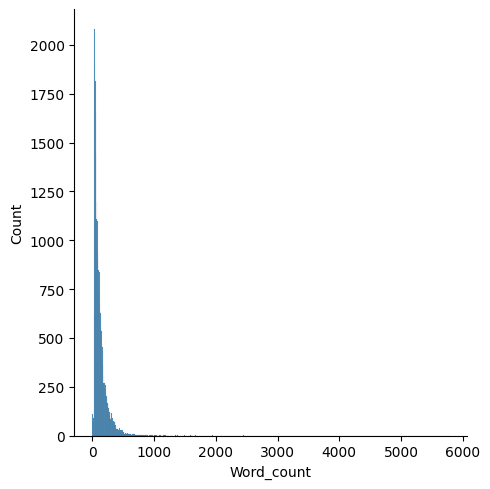

In [8]:
#TODO: Blow up the plot

sns.displot(df["Word_count"])

<Axes: >

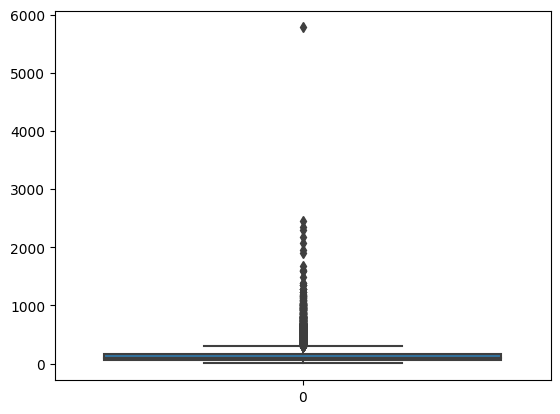

In [9]:
#TODO: Blow up the plot

sns.boxplot(df["Word_count"])

### IQR Method
To ensure accuracy, I will also use the IQR method to verify the validity or proximity of my observation.

In [10]:
q1 = df["Word_count"].quantile(0.25)
q3 = df["Word_count"].quantile(0.75)
iqr = q3-q1

The upper limit, which is 307.5, closely aligns with my observation. Therefore, I will round it up to 350.

In [11]:
upper_limit = q3 + (1.5 * iqr)
lower_limit = q1 - (1.5 * iqr)

upper_limit, lower_limit

(307.5, -96.5)

## Tokenizing the text. Creates a word-to-index dictionary

Once a word is tokenized, the assigned number represents its frequency within the text. The number 1 corresponds to the most frequently occurring word, and so forth.

In [12]:
# This is what the words look like before getting tokenized
print(x_train[4])
print(y_train[4])

wife stayed aplex london wall november come one night stay special treat anniversary hotel close liverpool station bank tube station heart city really nice welcome reception anh glass chilled prosseco given room balcony nice view city room verybig great facilitiesandalovely coffee machine realcoffeeforonce thebed nicely presented swans made towels heart shape made red petals also received aplex branded box chocolates bathrobes fluffy slippers romantic indeed room clean huge comfortable bed white crisp sheets nice feather ducks pillows impressed man point view condition room items paint ac mastic shower drain etc pristine condition impressive normally see hotel room nowadays declined service secondhand thoughts accepted see wife enjoyed massive stand bath decorated rose petals nicetoiletries elemis brand white fluffy towels food delicious service quick overall amazing experience worth every penny paid definitely return longer stay also recommend friends family 
1


In [13]:
# Let's check what our vocabulary size is
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train.copy())

VOCAB_SIZE = len(tokenizer.word_index)
print("Vocabulary size:", VOCAB_SIZE)

Vocabulary size: 52023


In [14]:
VOCAB_SIZE = 52234

#, lower=True
tokenizer = Tokenizer(VOCAB_SIZE)
tokenizer.fit_on_texts(x_train)

# Providing each token an integer
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [15]:
# This is what the words look like after beeing tokenized
print(x_train[4])
print(y_train[4])

[211, 19, 19831, 6, 407, 1741, 161, 16, 26, 7, 72, 231, 397, 2, 98, 1074, 83, 370, 73, 83, 779, 136, 29, 23, 221, 86, 26819, 528, 2445, 8475, 224, 3, 482, 23, 74, 136, 3, 26820, 11, 26821, 135, 796, 26822, 26823, 724, 660, 5739, 53, 569, 779, 3422, 53, 1561, 2291, 31, 497, 19831, 5411, 1365, 1001, 2242, 1763, 949, 1593, 944, 3, 37, 246, 36, 48, 945, 2619, 1742, 23, 4325, 7638, 681, 488, 363, 491, 74, 2038, 3, 840, 3152, 965, 19832, 80, 4255, 172, 4171, 2038, 697, 1310, 140, 2, 3, 5581, 2446, 10, 26824, 5118, 3027, 140, 211, 134, 1174, 1179, 173, 401, 1676, 2291, 26825, 2039, 1283, 945, 1763, 569, 34, 203, 10, 531, 174, 52, 47, 160, 68, 1018, 493, 71, 132, 974, 7, 31, 59, 356, 192]
1


## Padding the text

* If a review exceeds 350 words, we will remove the excess words.
* If a review contains less than 350 words, we will append zeros to it until it reaches a length of 750 words.

In [16]:
# Word lenghts before padding
len(x_train[0]), len(x_train[1]), len(x_train[2]), len(x_train[3]), len(x_train[4])

(27, 76, 66, 57, 137)

In [17]:
# Max length of words
MAXLEN = 350

x_train = keras.utils.pad_sequences(x_train, padding='post', maxlen=MAXLEN)
x_test = keras.utils.pad_sequences(x_test, padding='post', maxlen=MAXLEN)

In [18]:
# Word lenghts after padding
len(x_train[0]), len(x_train[1]), len(x_train[2]), len(x_train[3]), len(x_train[4])

(350, 350, 350, 350, 350)

In [19]:
# And this is what it looks like if we take a closer look
x_train[4]

array([  211,    19, 19831,     6,   407,  1741,   161,    16,    26,
           7,    72,   231,   397,     2,    98,  1074,    83,   370,
          73,    83,   779,   136,    29,    23,   221,    86, 26819,
         528,  2445,  8475,   224,     3,   482,    23,    74,   136,
           3, 26820,    11, 26821,   135,   796, 26822, 26823,   724,
         660,  5739,    53,   569,   779,  3422,    53,  1561,  2291,
          31,   497, 19831,  5411,  1365,  1001,  2242,  1763,   949,
        1593,   944,     3,    37,   246,    36,    48,   945,  2619,
        1742,    23,  4325,  7638,   681,   488,   363,   491,    74,
        2038,     3,   840,  3152,   965, 19832,    80,  4255,   172,
        4171,  2038,   697,  1310,   140,     2,     3,  5581,  2446,
          10, 26824,  5118,  3027,   140,   211,   134,  1174,  1179,
         173,   401,  1676,  2291, 26825,  2039,  1283,   945,  1763,
         569,    34,   203,    10,   531,   174,    52,    47,   160,
          68,  1018,

## One-Hot Encoding on y

In [20]:
# The assigned number is dependent on the type of rating being used, which is currently set to 0 or 1 in this instance.
# However, it is possible to modify this.
num_classes = 2

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print(y_train.shape)
print(y_test[0])

(21864, 2)
[0. 1.]


## Resaping the data from 2D to 3D

Recurrent Neural Networks (RNNs) require 3D input because they are designed to operate on sequences of data. The 3D input tensor consists of a batch size, sequence length, and feature dimensions.

* Batch size: The number of sequences in a batch, typically represented as the first dimension of the 3D tensor.
* Sequence length: The number of time steps in each sequence, represented as the second dimension of the 3D tensor.
* Feature dimensions: The number of features or variables in each time step, represented as the third dimension of the 3D tensor.

The 3D input tensor allows RNNs to process a sequence of data over time, where each time step contains a set of features. By using a 3D input, RNNs can learn and remember patterns and dependencies across multiple time steps, which is useful in a variety of applications such as natural language processing, speech recognition, and time series forecasting.

In [21]:
x_train = np.array(x_train).reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = np.array(x_test).reshape((x_test.shape[0], x_test.shape[1], 1))

print(x_train.shape)
print("Sentences:", x_train.shape[0], "Words:", x_train.shape[1], "TimeSteps:", x_train.shape[2], "\n")
print(x_test.shape)
print("Sentences:", x_test.shape[0], "Words:", x_test.shape[1], "TimeSteps:", x_test.shape[2])

(21864, 350, 1)
Sentences: 21864 Words: 350 TimeSteps: 1 

(5466, 350, 1)
Sentences: 5466 Words: 350 TimeSteps: 1


# Model Building

In [22]:
# NN Model
model = tf.keras.Sequential([
tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=50, input_length=MAXLEN),
tf.keras.layers.LSTM(32, return_sequences=True),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.LSTM(16, return_sequences=True),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(num_classes , activation="sigmoid"),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 350, 50)           2611700   
                                                                 
 lstm (LSTM)                 (None, 350, 32)           10624     
                                                                 
 dropout (Dropout)           (None, 350, 32)           0         
                                                                 
 lstm_1 (LSTM)               (None, 350, 16)           3136      
                                                                 
 dropout_1 (Dropout)         (None, 350, 16)           0         
                                                                 
 flatten (Flatten)           (None, 5600)              0         
                                                                 
 dense (Dense)               (None, 2)                 1

We are dealing with imbalanced data. It's important to adjust the weights of the classes to reflect their distribution. This can be done by calculating the class weights and passing them to the model during training.

The class weights can be calculated using various techniques such as inverse frequency, inverse square root frequency, or user-defined weights. Inverse frequency assigns a weight to each class that is inversely proportional to the number of samples in that class. Inverse square root frequency assigns a weight that is the inverse square root of the frequency of the class. User-defined weights allow the user to manually assign weights to each class based on their domain knowledge.

I opted for inverse frequency as you can seee below.

In [23]:
# Frequency
freq = pd.value_counts(df['Positive'])
freq

Positive
1    24347
0     2983
Name: count, dtype: int64

In [24]:
# Inverse frequency
weights = {0: freq.sum() / freq[0], 1: freq.sum() / freq[1]}
weights

{0: 9.161917532685216, 1: 1.122520228364891}

In [25]:

# Creating an instance of BinaryCrossentropy to pass into model.compile()
loss_fn = tf.keras.losses.BinaryCrossentropy()

# Creating checkpoint that saves the best model
cp = ModelCheckpoint('model/', save_best_only=True)

model.compile(optimizer=Adam(learning_rate=(0.0001)), loss=loss_fn, metrics=['accuracy', AUC(name='auc')])
rnn_model_history = model.fit(x_train, y_train, batch_size=150, epochs=10, validation_split=0.20, class_weight=weights, callbacks=[cp])

Epoch 1/10
117/117 [==============================] - ETA: 0s - loss: 1.3780 - accuracy: 0.7711 - auc: 0.8023

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


117/117 [==============================] - 67s 550ms/step - loss: 1.3780 - accuracy: 0.7711 - auc: 0.8023 - val_loss: 0.6445 - val_accuracy: 0.6625 - val_auc: 0.7035
Epoch 2/10
117/117 [==============================] - ETA: 0s - loss: 1.1670 - accuracy: 0.6880 - auc: 0.7509

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


117/117 [==============================] - 58s 500ms/step - loss: 1.1670 - accuracy: 0.6880 - auc: 0.7509 - val_loss: 0.4819 - val_accuracy: 0.8187 - val_auc: 0.8591
Epoch 3/10
117/117 [==============================] - ETA: 0s - loss: 0.5262 - accuracy: 0.9025 - auc: 0.9516

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


117/117 [==============================] - 59s 504ms/step - loss: 0.5262 - accuracy: 0.9025 - auc: 0.9516 - val_loss: 0.2088 - val_accuracy: 0.9190 - val_auc: 0.9728
Epoch 4/10
117/117 [==============================] - 59s 501ms/step - loss: 0.3312 - accuracy: 0.9395 - auc: 0.9804 - val_loss: 0.2600 - val_accuracy: 0.8992 - val_auc: 0.9622
Epoch 5/10
117/117 [==============================] - ETA: 0s - loss: 0.2434 - accuracy: 0.9534 - auc: 0.9879

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


117/117 [==============================] - 63s 538ms/step - loss: 0.2434 - accuracy: 0.9534 - auc: 0.9879 - val_loss: 0.2056 - val_accuracy: 0.9261 - val_auc: 0.9776
Epoch 6/10
117/117 [==============================] - 59s 502ms/step - loss: 0.1891 - accuracy: 0.9652 - auc: 0.9920 - val_loss: 0.2424 - val_accuracy: 0.9104 - val_auc: 0.9707
Epoch 7/10
117/117 [==============================] - 60s 515ms/step - loss: 0.1385 - accuracy: 0.9747 - auc: 0.9948 - val_loss: 0.2796 - val_accuracy: 0.9067 - val_auc: 0.9676
Epoch 8/10
117/117 [==============================] - 62s 530ms/step - loss: 0.1134 - accuracy: 0.9801 - auc: 0.9956 - val_loss: 0.2825 - val_accuracy: 0.9138 - val_auc: 0.9671
Epoch 9/10
117/117 [==============================] - 61s 520ms/step - loss: 0.0829 - accuracy: 0.9856 - auc: 0.9972 - val_loss: 0.3058 - val_accuracy: 0.9243 - val_auc: 0.9645
Epoch 10/10
117/117 [==============================] - 60s 517ms/step - loss: 0.0727 - accuracy: 0.9890 - auc: 0.9979 - val_lo

In [26]:
results = model.evaluate(x_test, y_test)

171/171 [==============================] - 8s 48ms/step - loss: 0.3527 - accuracy: 0.9171 - auc: 0.9570


#TODO: make this a comment instead with f string that gets the accuracy score and round it

So we're scoring somewhere in the high 80's. Not bad for a simple recurrent network.

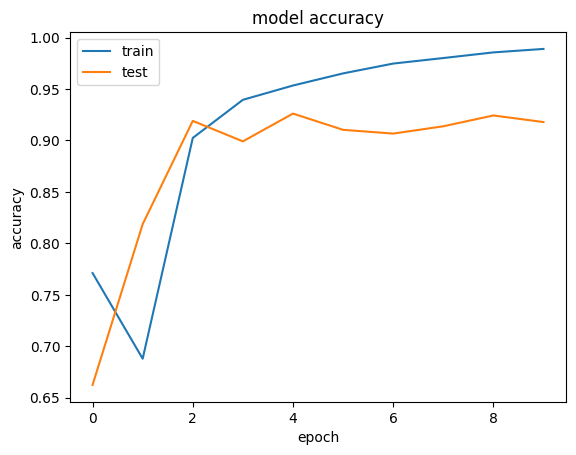

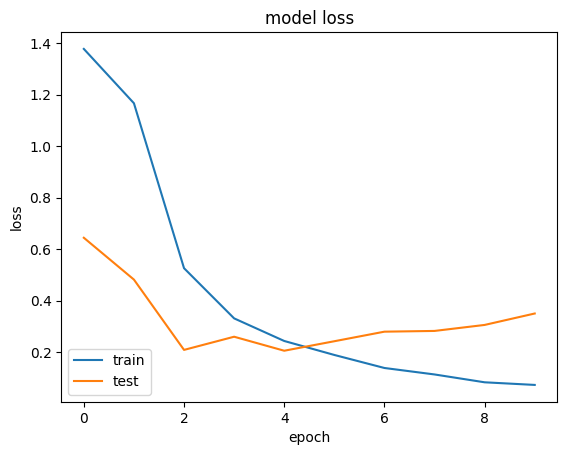

In [33]:
# Model Performance Chart

plt.plot(rnn_model_history.history['accuracy'])
plt.plot(rnn_model_history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(rnn_model_history.history['loss'])
plt.plot(rnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower left')
plt.show()

#TODO: make this a comment instead with f string that gets the score and round it


Looking at this output, the accuracy score for the training set is around 89-90%, while the accuracy score for the validation set is around 90-91%. This suggests that the model is performing well and not overfitting too much to the training data. The loss scores are also decreasing with each epoch, which is a good sign that the model is learning from the data.

## Model Evaluation

Let's evaluate the model to see how well it did

### AUC-ROC score

In [28]:
# AUC-ROC score
y_pred = model.predict(x_test)
roc_auc = roc_auc_score(y_test, y_pred)
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred[:, i])
print('AUC-ROC score:', roc_auc)

171/171 [==============================] - 8s 46ms/step
AUC-ROC score: 0.9217605447889134


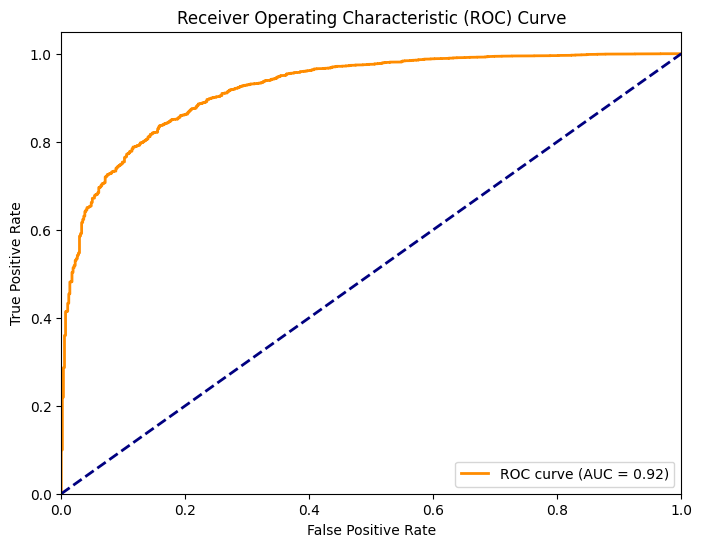

In [29]:
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


Great! The ROC AUC score of my model is 0.901998439517365 which indicates that my model is performing well. A value of 0.5 indicates random guessing, while a value of 1 indicates perfect performance. A score between 0.7 to 0.9 is considered good, while a score above 0.9 is considered excellent. Therefore, I would say my model is performing well in terms of its ability to distinguish between positive and negative samples.

### Confusion Mtrix

In [ ]:
# Get the predicted labels for the test set
y_pred = model.predict(x_test)
y_pred = (y_pred > 0.5)

# Create the confusion matrix
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

print(cm)

In [ ]:
cm[1][1]

In [ ]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#TODO: make this a comment instead with f string that gets the score and rounds it


Based on the output, the confusion matrix has four values - true negatives (TN), false positives (FP), false negatives (FN), and true positives (TP). The matrix is a 2x2 matrix, with the top row representing the actual negatives and the bottom row representing the actual positives. The left column represents the predicted negatives and the right column represents the predicted positives.

Here, the model predicted 321 true negatives and 4705 true positives. It also predicted 276 false positives and 164 false negatives.

# Making Predictions

Next, we will utilize our neural network to predict the sentiment of our own reviews. However, since the reviews are encoded, we need to convert our new reviews into the same encoding format so that the network can process them. To accomplish this, we will load the encodings from the existing dataset and apply them to our new data.

In [ ]:
data = initial_processing_df
data.head()

In [ ]:
# Preprocessing the new text with the process function I created earlier

unseen_reviews = data['Review']

#unseen_processed = []
#for review in unseen_reviews:
#    review = preprocess_text(review)
#    unseen_processed.append(review)

In [ ]:
# Tokenizing the text
unseen_tokenized = tokenizer.texts_to_sequences(unseen_reviews)

# Pooling instance to have maxlength of 100 tokens
unseen_padded = keras.utils.pad_sequences(unseen_tokenized, padding='post', maxlen=MAXLEN)

In [ ]:
unseen_sentiments = model.predict(unseen_padded)

In [ ]:
res = {}

for i, row in data.iterrows(), total=len(data)):
    text = row['Review']
    myid = row['id']
    unseen_sentiments = model.predict(unseen_padded)
    